<div><span style="background-color: #9e4244; padding-top: 80px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: white; font-size: 22px; font-weight: bold">Session 8: Machine Learning Pipelines</span></div>

by BYJ Cirio

<div class="alert alert-danger alert-info">
     In this notebook you will learn how to automate your machine learning model pipelines. Specifically, the topics covered are as follows:<br>
    <ol>
        <li>Auto-ML</li>
        <li>Grid-search CV/Randomized Search CV</li>
        <li>Example project</li>
    </ol>
</div>

In [1]:
# General Libraries
import re
import time
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# Visualizations
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score)

# Imblearn
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                     EditedNearestNeighbours, 
                                     RepeatedEditedNearestNeighbours) 
from imblearn.combine import SMOTETomek, SMOTEENN

# SHAP
import shap

In [12]:
df = pd.read_csv('cc_df_group1_version2.csv', nrows=100000)

df.drop(columns = ['trans_date'], inplace = True)

In [13]:
df.head()

,lat,long,city_pop,amt,is_fraud,merch_lat,merch_long,trans_day,city_Angeles City,city_Antipolo,...,part_of_day_lunch,region_CALABARZON,region_NCR,region_Region 3,quarantine_status_ECQ,quarantine_status_GCQ,quarantine_status_MECQ,quarantine_status_Normal,QL_Extreme QL,QL_Moderate-Low QL
0,14.5958,120.9772,23088000,966.24,1,14.133430,121.223118,13,0,0,...,1,0,1,0,0,1,0,0,0,1
1,14.5958,120.9772,23088000,275.37,1,15.290354,120.246084,13,0,0,...,0,0,1,0,0,1,0,0,0,1
2,14.5958,120.9772,23088000,326.96,1,15.402101,121.332516,14,0,0,...,0,0,1,0,0,1,0,0,0,1
3,14.5958,120.9772,23088000,1047.59,1,15.166276,121.955649,14,0,0,...,0,0,1,0,0,1,0,0,0,1
4,14.5958,120.9772,23088000,286.34,1,15.149144,121.696662,14,0,0,...,0,0,1,0,0,1,0,0,0,1


Would Recommend:       0
1    300
0  29677
Proportion Chance Criterion: 98.02%
1.25 * Proportion Chance Criterion: 122.52%


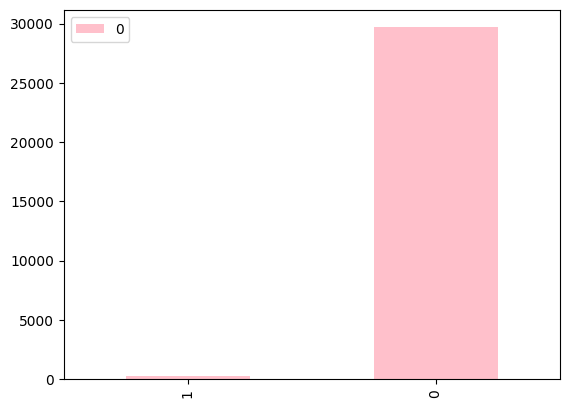

In [14]:
state_counts = Counter(df['is_fraud'])
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
df_state.plot(kind='bar', color='pink')

num=(df_state[0]/df_state[0].sum())**2

print("Would Recommend:{}".format(df_state))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

In [15]:
X = df.drop(['is_fraud'], axis=1)
y = df['is_fraud']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                                                  random_state=11, test_size=0.25,
                                                                  stratify=y)

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Auto-ML </span></div>

In [5]:
def auto_ml(X, y, models_dict, scaler=None, cv=None, res_t=None):
    """Apply resampling for imbalanced data"""
    results = {}
    results2 = {}

    # log start time
    total_start = time.time()

    for model_name, model in tqdm(models_dict.items()):
        
        ################# this portion can be edited ###############
        train_scores = []
        val_scores = []

        train_recall = []
        val_recall = []

        ###########################################################

        for train_index, val_index in tqdm(cv.split(X, y)):

            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Apply scaling
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else:
                pass

            # Apply resampling
            if res_t is not None:
                s = time.time()
                X_train, y_train = res_t.fit_resample(X_train, y_train)
                print(f'Resampling done in {time.time() - s}')
            else:
                pass

            start_time = time.time()

            # fit
            model.fit(X_train, y_train)

            # predict
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            ################# this portion can be edited ###############

            # classification accuracy
            train_scores.append(model.score(X_train, y_train))
            val_scores.append(model.score(X_val, y_val))

            # recall
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))

            end_time = time.time()

            results[model_name] = {
                'Train Accuracy': np.round(np.mean(train_scores) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_scores) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Run Time': end_time - start_time
            }

            results2[model_name] = {
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_scores)*100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_scores)*100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall)*100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall)*100, 2)),
                'Run Time': end_time - start_time
            }
            
            ###########################################################

    results = pd.DataFrame(results).T
    results2 = pd.DataFrame(results2).T
    return [results, results2]

### Baseline

In [6]:
models_dict = {'DecisionTreeClassifier': DecisionTreeClassifier(random_state = 143)}

# models_dict = {
#     'KNeighborsClassifier': KNeighborsClassifier(),
#     'LogisticRegressor': LogisticRegression(),
#     'GaussianNB': GaussianNB(),
#     'RandomForestClassifier': RandomForestClassifier(random_state=143),
#     'DecisionTreeClassifier': DecisionTreeClassifier(random_state=143),
#     'GradientBoostingClassifier': GradientBoostingClassifier(random_state=143)   
# }

In [16]:
auto_run = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
               cv=StratifiedKFold(n_splits=5))
auto = auto_run[0]
auto_run[1]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
DecisionTreeClassifier,0.284297,100.00%,100.00%,99.81%,89.33%


### Applying resampling techniques

#### Oversampling

In [17]:
res_list = [('SMOTE', SMOTE()),
            ('ADASYN', ADASYN()),
            ('BorderlineSMOTE', BorderlineSMOTE()),
            ('SVMSMOTE', SVMSMOTE())]

outputs = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                    cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs.append(var[0])
    display(var[1])

---------------------------------------------------SMOTE---------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.26044487953186035
Resampling done in 0.15355396270751953
Resampling done in 0.13272500038146973
Resampling done in 0.14435768127441406
Resampling done in 0.13139104843139648


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
DecisionTreeClassifier,2.058789,100.00%,100.00%,99.60%,76.89%


--------------------------------------------------ADASYN---------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.19404911994934082
Resampling done in 0.17281723022460938
Resampling done in 0.16272306442260742
Resampling done in 0.1667172908782959
Resampling done in 0.17032289505004883


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
DecisionTreeClassifier,2.343992,100.00%,100.00%,99.54%,74.22%


----------------------------------------------BorderlineSMOTE----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.22024321556091309
Resampling done in 0.19822406768798828
Resampling done in 0.17320013046264648
Resampling done in 0.16846632957458496
Resampling done in 0.17152619361877441


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
DecisionTreeClassifier,2.096705,100.00%,100.00%,99.62%,78.22%


-------------------------------------------------SVMSMOTE--------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 2.959696054458618
Resampling done in 2.9363529682159424
Resampling done in 2.6879920959472656
Resampling done in 2.665510892868042
Resampling done in 2.849803924560547


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
DecisionTreeClassifier,2.214919,100.00%,100.00%,99.52%,74.67%


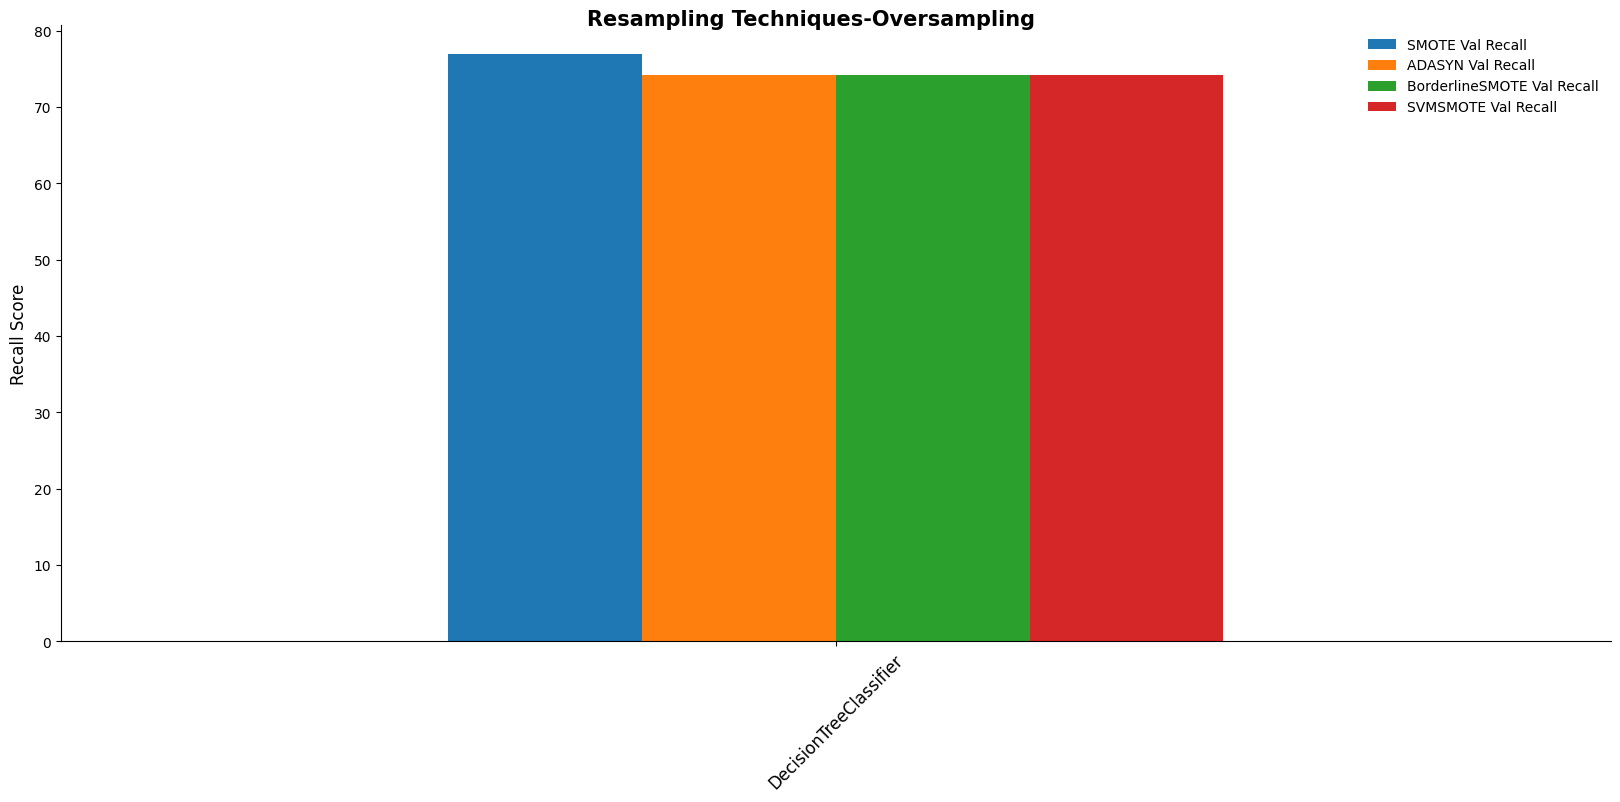

In [18]:
ps_over = pd.DataFrame(index=models_dict.keys())
ps_over['NoResampling Val Recall'] = auto_run[1]['Val Recall']
ps_over['SMOTE Val Recall'] = outputs[0]['Val Recall']
ps_over['ADASYN Val Recall'] = outputs[1]['Val Recall']
ps_over['BorderlineSMOTE Val Recall'] = outputs[1]['Val Recall']
ps_over['SVMSMOTE Val Recall'] = outputs[1]['Val Recall']
fig, ax = plt.subplots(figsize=(20, 8))
ps_over.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

#### Undersampling

In [19]:
res_list = [('TomekLinks', TomekLinks()),
            ('NearMiss', NearMiss()),
            ('ALLKNN', AllKNN()),
            ('EditedNearestNeighbours', EditedNearestNeighbours()),
            ('RepeatedEditedNearestNeighbours', RepeatedEditedNearestNeighbours())]

outputs_u = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_u.append(var[0])
    display(var[1])

------------------------------------------------TomekLinks-------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 1.52490234375
Resampling done in 1.3689711093902588
Resampling done in 1.3350841999053955
Resampling done in 1.2518987655639648
Resampling done in 1.250385046005249


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
DecisionTreeClassifier,0.58364,100.00%,100.00%,99.81%,89.78%


-------------------------------------------------NearMiss--------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.09659385681152344
Resampling done in 0.08175492286682129
Resampling done in 0.07583928108215332
Resampling done in 0.07458972930908203
Resampling done in 0.07388114929199219


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
DecisionTreeClassifier,0.014653,100.00%,100.00%,93.34%,93.78%


--------------------------------------------------ALLKNN---------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 3.78267502784729
Resampling done in 4.00874400138855
Resampling done in 4.144127130508423
Resampling done in 4.0183281898498535
Resampling done in 4.226196050643921


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
DecisionTreeClassifier,0.748506,100.00%,100.00%,99.74%,87.56%


------------------------------------------EditedNearestNeighbours------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 1.3240420818328857
Resampling done in 1.3046648502349854
Resampling done in 1.3122780323028564
Resampling done in 1.3667502403259277
Resampling done in 1.5982410907745361


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
DecisionTreeClassifier,0.619467,100.00%,100.00%,99.73%,87.11%


--------------------------------------RepeatedEditedNearestNeighbours--------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 5.839201927185059
Resampling done in 7.730304956436157
Resampling done in 7.403223037719727
Resampling done in 5.657505989074707
Resampling done in 7.8187971115112305


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
DecisionTreeClassifier,0.765619,100.00%,100.00%,99.74%,87.56%


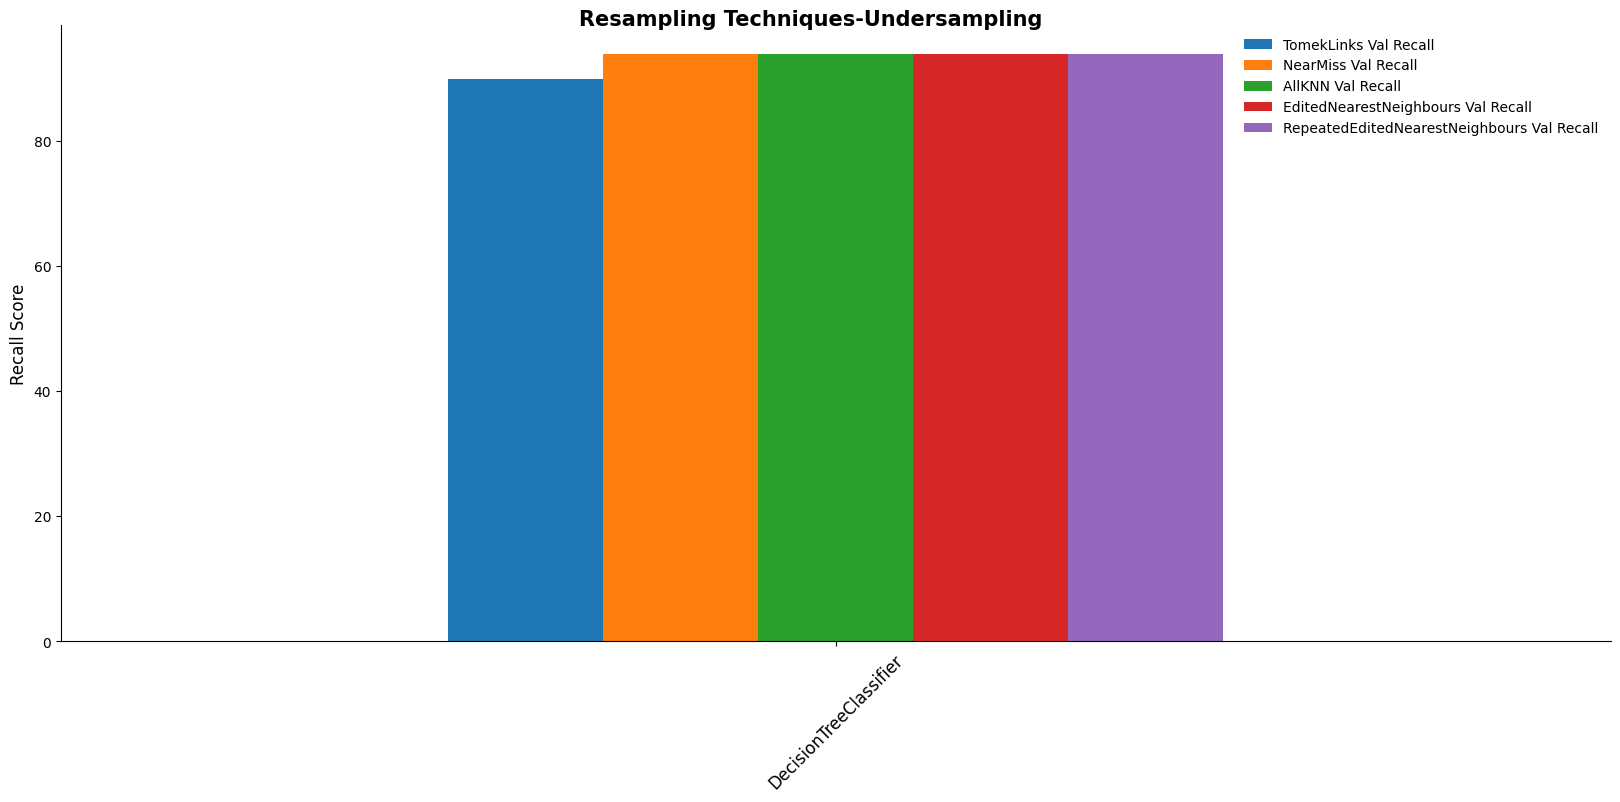

In [20]:
ps_under = pd.DataFrame(index=models_dict.keys())
ps_under['NoResampling Val Recall'] = auto_run[1]['Val Recall']
ps_under['TomekLinks Val Recall'] = outputs_u[0]['Val Recall']
ps_under['NearMiss Val Recall'] = outputs_u[1]['Val Recall']
ps_under['AllKNN Val Recall'] = outputs_u[1]['Val Recall']
ps_under['EditedNearestNeighbours Val Recall'] = outputs_u[1]['Val Recall']
ps_under['RepeatedEditedNearestNeighbours Val Recall'] = outputs_u[1]['Val Recall']

fig, ax = plt.subplots(figsize=(20, 8))
ps_under.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

#### Combined Resampling

In [21]:
res_list = [('SMOTETomek', SMOTETomek()),
            ('SMOTEENN', SMOTEENN())]

outputs_c = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_c.append(var[0])
    display(var[1])

------------------------------------------------SMOTETomek-------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 4.968634843826294
Resampling done in 5.129055976867676
Resampling done in 5.44655704498291
Resampling done in 5.047973871231079
Resampling done in 5.283674955368042


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
DecisionTreeClassifier,2.722636,100.00%,100.00%,99.58%,77.33%


-------------------------------------------------SMOTEENN--------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 5.260458946228027
Resampling done in 5.28243088722229
Resampling done in 5.466449975967407
Resampling done in 5.622291803359985
Resampling done in 5.508720874786377


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
DecisionTreeClassifier,2.339234,100.00%,100.00%,99.56%,76.00%


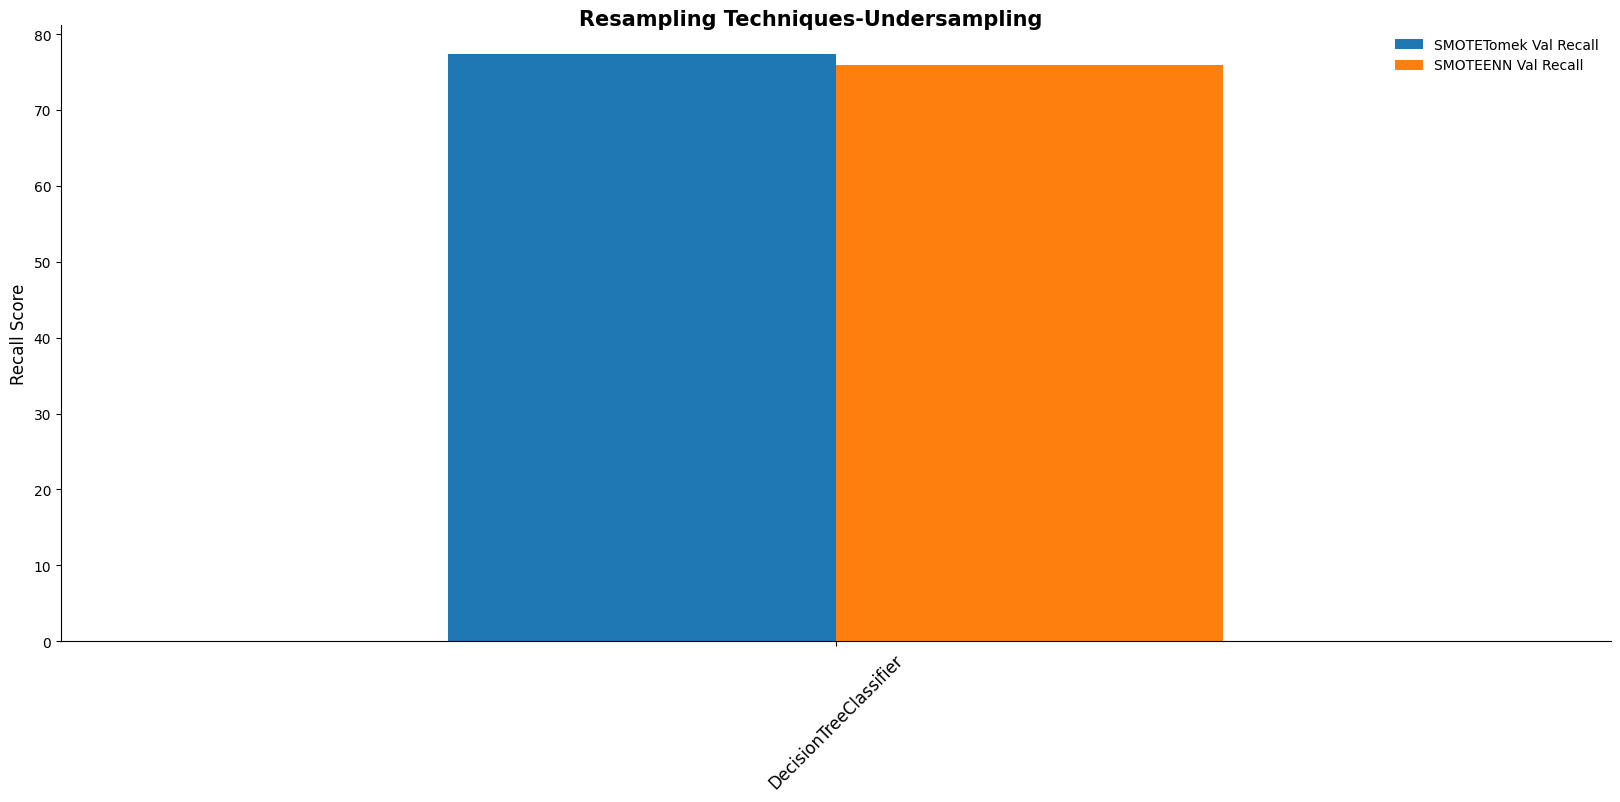

In [22]:
ps_under = pd.DataFrame(index=models_dict.keys())
ps_under['NoResampling Val Recall'] = auto_run[1]['Val Recall']
ps_under['SMOTETomek Val Recall'] = outputs_c[0]['Val Recall']
ps_under['SMOTEENN Val Recall'] = outputs_c[1]['Val Recall']

fig, ax = plt.subplots(figsize=(20, 8))
ps_under.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Grid-Search and Randomized Search Cross Validation </span></div>

[Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [Randomized Search Cross Validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) are commonly used to hypertune models across multiple parameters

In [23]:
def train_dc(X, y, metric, res_t=None, hypertune=False, resample=False):
    """Hypertune Decision Tree and apply NearMiss()"""
    params = {'min_samples_leaf': list(range(1,6)),
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': list(range(3, 20))
              }
    new_params = {'decisiontreeclassifier__' +
                  key: params[key] for key in params}

    skf = StratifiedKFold(n_splits=5)
    if resample is True:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                      res_t,
                                      DecisionTreeClassifier(random_state=143))
    else:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                      DecisionTreeClassifier(random_state=143))

    if hypertune is True:
        clf = GridSearchCV(imba_pipeline, param_grid=new_params,
                           cv=skf, scoring=metric, return_train_score=True,
                          verbose=10)
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        model = clf.best_estimator_.fit(X, y)
        return ['Decision Tree Classifier', np.mean(clf.cv_results_['mean_train_score']),
                clf.best_score_, 'Best parameters = {0}'.format(
                    clf.best_params_),
                run_time, model]
    else:
        clf = imba_pipeline
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        cv_scores = cross_validate(estimator=clf, X=X, y=y,
                                   scoring=metric, cv=skf, n_jobs=-1,
                                   return_train_score=True)

        return ['Decision Tree Classifier', np.mean(cv_scores['train_score']),
                np.mean(cv_scores['test_score']), run_time, clf]

In [26]:
start_time = time.time()
dc_nm_rec = train_dc(X_trainval, y_trainval, 'recall', NearMiss(),
                       hypertune=True, resample=True)
start_time = time.time()
dc_nm_acc = train_dc(X_trainval, y_trainval, 'accuracy', NearMiss(),
                      hypertune=True, resample=True)

Fitting 5 folds for each of 255 candidates, totalling 1275 fits
[CV 1/5; 1/255] START decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1
[CV 1/5; 1/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.850, test=0.822) total time=   0.2s
[CV 2/5; 1/255] START decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1
[CV 2/5; 1/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.861, test=0.822) total time=   0.2s
[CV 3/5; 1/255] START decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1
[CV 3/5; 1/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=auto, decisiont

[CV 5/5; 5/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.850, test=0.778) total time=   0.2s
[CV 1/5; 6/255] START decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1
[CV 1/5; 6/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.850, test=0.822) total time=   0.2s
[CV 2/5; 6/255] START decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1
[CV 2/5; 6/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.861, test=0.822) total time=   0.2s
[CV 3/5; 6/255] START decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifi

[CV 5/5; 10/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.850, test=0.778) total time=   0.2s
[CV 1/5; 11/255] START decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1
[CV 1/5; 11/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.856, test=0.822) total time=   0.2s
[CV 2/5; 11/255] START decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1
[CV 2/5; 11/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.844, test=0.822) total time=   0.2s
[CV 3/5; 11/255] START decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=log2, decisiontreecl

[CV 4/5; 15/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.828, test=0.867) total time=   0.2s
[CV 5/5; 15/255] START decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5
[CV 5/5; 15/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.850, test=0.778) total time=   0.2s
[CV 1/5; 16/255] START decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1
[CV 1/5; 16/255] END decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.867, test=0.822) total time=   0.2s
[CV 2/5; 16/255] START decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=auto, decisiontreecl

[CV 3/5; 20/255] END decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.839, test=0.889) total time=   0.2s
[CV 4/5; 20/255] START decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5
[CV 4/5; 20/255] END decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.950, test=0.889) total time=   0.2s
[CV 5/5; 20/255] START decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5
[CV 5/5; 20/255] END decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.878, test=0.822) total time=   0.2s
[CV 1/5; 21/255] START decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=sqrt, decisiontreecl

[CV 2/5; 25/255] END decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.839, test=0.822) total time=   0.2s
[CV 3/5; 25/255] START decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5
[CV 3/5; 25/255] END decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.839, test=0.889) total time=   0.2s
[CV 4/5; 25/255] START decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5
[CV 4/5; 25/255] END decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.950, test=0.889) total time=   0.2s
[CV 5/5; 25/255] START decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=sqrt, decisiontreecl

[CV 1/5; 30/255] END decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.839, test=0.822) total time=   0.2s
[CV 2/5; 30/255] START decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5
[CV 2/5; 30/255] END decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.839, test=0.822) total time=   0.2s
[CV 3/5; 30/255] START decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5
[CV 3/5; 30/255] END decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.822, test=0.889) total time=   0.2s
[CV 4/5; 30/255] START decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=log2, decisiontreecl

[CV 5/5; 34/255] END decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.867, test=0.822) total time=   0.2s
[CV 1/5; 35/255] START decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5
[CV 1/5; 35/255] END decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.883, test=0.844) total time=   0.2s
[CV 2/5; 35/255] START decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5
[CV 2/5; 35/255] END decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.839, test=0.822) total time=   0.2s
[CV 3/5; 35/255] START decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=auto, decisiontreecl

[CV 4/5; 39/255] END decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.989, test=0.933) total time=   0.2s
[CV 5/5; 39/255] START decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4
[CV 5/5; 39/255] END decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.867, test=0.822) total time=   0.2s
[CV 1/5; 40/255] START decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5
[CV 1/5; 40/255] END decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.883, test=0.844) total time=   0.2s
[CV 2/5; 40/255] START decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=sqrt, decisiontreecl

[CV 3/5; 44/255] END decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.822, test=0.889) total time=   0.2s
[CV 4/5; 44/255] START decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4
[CV 4/5; 44/255] END decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.861, test=0.889) total time=   0.2s
[CV 5/5; 44/255] START decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4
[CV 5/5; 44/255] END decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.850, test=0.778) total time=   0.2s
[CV 1/5; 45/255] START decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=log2, decisiontreecl

[CV 2/5; 49/255] END decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.867, test=0.844) total time=   0.2s
[CV 3/5; 49/255] START decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4
[CV 3/5; 49/255] END decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.983, test=1.000) total time=   0.2s
[CV 4/5; 49/255] START decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4
[CV 4/5; 49/255] END decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.989, test=0.933) total time=   0.2s
[CV 5/5; 49/255] START decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=auto, decisiontreecl

[CV 1/5; 54/255] END decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.911, test=0.822) total time=   0.2s
[CV 2/5; 54/255] START decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4
[CV 2/5; 54/255] END decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.867, test=0.844) total time=   0.2s
[CV 3/5; 54/255] START decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4
[CV 3/5; 54/255] END decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.983, test=1.000) total time=   0.2s
[CV 4/5; 54/255] START decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=sqrt, decisiontreecl

[CV 5/5; 58/255] END decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.861, test=0.778) total time=   0.2s
[CV 1/5; 59/255] START decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4
[CV 1/5; 59/255] END decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.839, test=0.822) total time=   0.2s
[CV 2/5; 59/255] START decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4
[CV 2/5; 59/255] END decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.839, test=0.822) total time=   0.2s
[CV 3/5; 59/255] START decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=log2, decisiontreecl

[CV 4/5; 63/255] END decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.961, test=0.933) total time=   0.2s
[CV 5/5; 63/255] START decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3
[CV 5/5; 63/255] END decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.939, test=0.822) total time=   0.2s
[CV 1/5; 64/255] START decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4
[CV 1/5; 64/255] END decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.922, test=0.844) total time=   0.2s
[CV 2/5; 64/255] START decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=auto, decisiontreecl

[CV 3/5; 68/255] END decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.883, test=0.889) total time=   0.2s
[CV 4/5; 68/255] START decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3
[CV 4/5; 68/255] END decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.961, test=0.933) total time=   0.2s
[CV 5/5; 68/255] START decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3
[CV 5/5; 68/255] END decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.939, test=0.822) total time=   0.2s
[CV 1/5; 69/255] START decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=sqrt, decisiontreecl

[CV 2/5; 73/255] END decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.856, test=0.822) total time=   0.2s
[CV 3/5; 73/255] START decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3
[CV 3/5; 73/255] END decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.822, test=0.889) total time=   0.2s
[CV 4/5; 73/255] START decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3
[CV 4/5; 73/255] END decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.861, test=0.889) total time=   0.2s
[CV 5/5; 73/255] START decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=log2, decisiontreecl

[CV 1/5; 78/255] END decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.850, test=0.822) total time=   0.2s
[CV 2/5; 78/255] START decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3
[CV 2/5; 78/255] END decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.928, test=0.911) total time=   0.2s
[CV 3/5; 78/255] START decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3
[CV 3/5; 78/255] END decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.983, test=0.978) total time=   0.2s
[CV 4/5; 78/255] START decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=auto, decisiontreecl

[CV 5/5; 82/255] END decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.911, test=0.800) total time=   0.2s
[CV 1/5; 83/255] START decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3
[CV 1/5; 83/255] END decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.850, test=0.822) total time=   0.2s
[CV 2/5; 83/255] START decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3
[CV 2/5; 83/255] END decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.928, test=0.911) total time=   0.2s
[CV 3/5; 83/255] START decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=sqrt, decisiontreecl

[CV 4/5; 87/255] END decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.906, test=0.911) total time=   0.2s
[CV 5/5; 87/255] START decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2
[CV 5/5; 87/255] END decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.861, test=0.778) total time=   0.2s
[CV 1/5; 88/255] START decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3
[CV 1/5; 88/255] END decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.872, test=0.822) total time=   0.2s
[CV 2/5; 88/255] START decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=log2, decisiontreecl

[CV 3/5; 92/255] END decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.972, test=0.911) total time=   0.2s
[CV 4/5; 92/255] START decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2
[CV 4/5; 92/255] END decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.972, test=0.933) total time=   0.2s
[CV 5/5; 92/255] START decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2
[CV 5/5; 92/255] END decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.917, test=0.800) total time=   0.2s
[CV 1/5; 93/255] START decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=auto, decisiontreecl

[CV 2/5; 97/255] END decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.889, test=0.822) total time=   0.2s
[CV 3/5; 97/255] START decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2
[CV 3/5; 97/255] END decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.972, test=0.911) total time=   0.2s
[CV 4/5; 97/255] START decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2
[CV 4/5; 97/255] END decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.972, test=0.933) total time=   0.2s
[CV 5/5; 97/255] START decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=sqrt, decisiontreecl

[CV 1/5; 102/255] END decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.889, test=0.844) total time=   0.2s
[CV 2/5; 102/255] START decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2
[CV 2/5; 102/255] END decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.844, test=0.822) total time=   0.2s
[CV 3/5; 102/255] START decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2
[CV 3/5; 102/255] END decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.822, test=0.844) total time=   0.2s
[CV 4/5; 102/255] START decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=log2, decision

[CV 5/5; 106/255] END decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=1.000, test=0.956) total time=   0.2s
[CV 1/5; 107/255] START decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2
[CV 1/5; 107/255] END decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.894, test=0.822) total time=   0.2s
[CV 2/5; 107/255] START decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2
[CV 2/5; 107/255] END decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.950, test=0.911) total time=   0.2s
[CV 3/5; 107/255] START decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=auto, de

[CV 4/5; 111/255] END decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=1.000, test=0.933) total time=   0.2s
[CV 5/5; 111/255] START decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1
[CV 5/5; 111/255] END decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=1.000, test=0.956) total time=   0.2s
[CV 1/5; 112/255] START decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2
[CV 1/5; 112/255] END decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.894, test=0.822) total time=   0.2s
[CV 2/5; 112/255] START decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=sqrt, de

[CV 3/5; 116/255] END decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=1.000, test=0.933) total time=   0.2s
[CV 4/5; 116/255] START decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1
[CV 4/5; 116/255] END decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.911, test=0.822) total time=   0.2s
[CV 5/5; 116/255] START decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1
[CV 5/5; 116/255] END decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.972, test=0.911) total time=   0.2s
[CV 1/5; 117/255] START decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=log2, de

[CV 2/5; 121/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.961, test=0.867) total time=   0.2s
[CV 3/5; 121/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1
[CV 3/5; 121/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=1.000, test=0.889) total time=   0.2s
[CV 4/5; 121/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1
[CV 4/5; 121/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=1.000, test=0.889) total time=   0.2s
[CV 5/5; 121/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=auto, de

[CV 1/5; 126/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.994, test=0.933) total time=   0.2s
[CV 2/5; 126/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1
[CV 2/5; 126/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.961, test=0.867) total time=   0.2s
[CV 3/5; 126/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1
[CV 3/5; 126/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=1.000, test=0.889) total time=   0.2s
[CV 4/5; 126/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=sqrt, de

[CV 5/5; 130/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.900, test=0.822) total time=   0.2s
[CV 1/5; 131/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1
[CV 1/5; 131/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.906, test=0.867) total time=   0.2s
[CV 2/5; 131/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1
[CV 2/5; 131/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.933, test=0.844) total time=   0.2s
[CV 3/5; 131/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=log2, de

[CV 4/5; 135/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.861, test=0.889) total time=   0.2s
[CV 5/5; 135/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5
[CV 5/5; 135/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.878, test=0.822) total time=   0.2s
[CV 1/5; 136/255] START decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1
[CV 1/5; 136/255] END decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=1.000, test=0.911) total time=   0.2s
[CV 2/5; 136/255] START decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=auto, de

[CV 3/5; 140/255] END decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.950, test=0.956) total time=   0.2s
[CV 4/5; 140/255] START decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5
[CV 4/5; 140/255] END decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.978, test=0.911) total time=   0.2s
[CV 5/5; 140/255] START decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5
[CV 5/5; 140/255] END decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.900, test=0.822) total time=   0.2s
[CV 1/5; 141/255] START decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=sqrt, de

[CV 2/5; 145/255] END decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.911, test=0.889) total time=   0.2s
[CV 3/5; 145/255] START decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5
[CV 3/5; 145/255] END decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.950, test=0.956) total time=   0.2s
[CV 4/5; 145/255] START decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5
[CV 4/5; 145/255] END decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.978, test=0.911) total time=   0.2s
[CV 5/5; 145/255] START decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=sqrt, de

[CV 1/5; 150/255] END decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.839, test=0.822) total time=   0.2s
[CV 2/5; 150/255] START decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5
[CV 2/5; 150/255] END decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.839, test=0.822) total time=   0.2s
[CV 3/5; 150/255] START decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5
[CV 3/5; 150/255] END decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.822, test=0.889) total time=   0.2s
[CV 4/5; 150/255] START decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=log2, de

[CV 5/5; 154/255] END decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.900, test=0.822) total time=   0.2s
[CV 1/5; 155/255] START decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5
[CV 1/5; 155/255] END decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.922, test=0.844) total time=   0.2s
[CV 2/5; 155/255] START decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5
[CV 2/5; 155/255] END decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.911, test=0.889) total time=   0.2s
[CV 3/5; 155/255] START decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=auto, de

[CV 4/5; 159/255] END decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.989, test=0.933) total time=   0.2s
[CV 5/5; 159/255] START decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4
[CV 5/5; 159/255] END decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.900, test=0.822) total time=   0.2s
[CV 1/5; 160/255] START decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5
[CV 1/5; 160/255] END decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.922, test=0.844) total time=   0.2s
[CV 2/5; 160/255] START decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=sqrt, de

[CV 3/5; 164/255] END decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.822, test=0.889) total time=   0.2s
[CV 4/5; 164/255] START decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4
[CV 4/5; 164/255] END decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.861, test=0.889) total time=   0.2s
[CV 5/5; 164/255] START decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4
[CV 5/5; 164/255] END decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.850, test=0.778) total time=   0.2s
[CV 1/5; 165/255] START decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=log2, de

[CV 2/5; 169/255] END decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.928, test=0.933) total time=   0.2s
[CV 3/5; 169/255] START decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4
[CV 3/5; 169/255] END decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.878, test=0.889) total time=   0.2s
[CV 4/5; 169/255] START decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4
[CV 4/5; 169/255] END decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.989, test=0.933) total time=   0.2s
[CV 5/5; 169/255] START decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=auto, de

[CV 1/5; 174/255] END decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.894, test=0.822) total time=   0.2s
[CV 2/5; 174/255] START decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4
[CV 2/5; 174/255] END decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.928, test=0.933) total time=   0.2s
[CV 3/5; 174/255] START decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4
[CV 3/5; 174/255] END decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.878, test=0.889) total time=   0.2s
[CV 4/5; 174/255] START decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=sqrt, de

[CV 5/5; 178/255] END decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.867, test=0.778) total time=   0.2s
[CV 1/5; 179/255] START decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4
[CV 1/5; 179/255] END decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.839, test=0.822) total time=   0.2s
[CV 2/5; 179/255] START decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4
[CV 2/5; 179/255] END decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.839, test=0.822) total time=   0.2s
[CV 3/5; 179/255] START decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=log2, de

[CV 4/5; 183/255] END decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.972, test=0.933) total time=   0.2s
[CV 5/5; 183/255] START decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3
[CV 5/5; 183/255] END decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.928, test=0.822) total time=   0.2s
[CV 1/5; 184/255] START decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4
[CV 1/5; 184/255] END decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.894, test=0.822) total time=   0.2s
[CV 2/5; 184/255] START decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=auto, de

[CV 3/5; 188/255] END decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.989, test=0.956) total time=   0.2s
[CV 4/5; 188/255] START decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3
[CV 4/5; 188/255] END decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.972, test=0.933) total time=   0.2s
[CV 5/5; 188/255] START decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3
[CV 5/5; 188/255] END decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.928, test=0.822) total time=   0.2s
[CV 1/5; 189/255] START decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=sqrt, de

[CV 2/5; 193/255] END decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.856, test=0.822) total time=   0.2s
[CV 3/5; 193/255] START decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3
[CV 3/5; 193/255] END decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.822, test=0.889) total time=   0.2s
[CV 4/5; 193/255] START decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3
[CV 4/5; 193/255] END decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.883, test=0.889) total time=   0.2s
[CV 5/5; 193/255] START decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=log2, de

[CV 1/5; 198/255] END decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.894, test=0.867) total time=   0.2s
[CV 2/5; 198/255] START decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3
[CV 2/5; 198/255] END decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.978, test=0.933) total time=   0.2s
[CV 3/5; 198/255] START decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3
[CV 3/5; 198/255] END decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.989, test=0.956) total time=   0.2s
[CV 4/5; 198/255] START decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=auto, de

[CV 5/5; 202/255] END decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.967, test=0.844) total time=   0.2s
[CV 1/5; 203/255] START decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3
[CV 1/5; 203/255] END decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.894, test=0.867) total time=   0.2s
[CV 2/5; 203/255] START decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3
[CV 2/5; 203/255] END decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.978, test=0.933) total time=   0.2s
[CV 3/5; 203/255] START decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=sqrt, de

[CV 4/5; 207/255] END decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.894, test=0.889) total time=   0.2s
[CV 5/5; 207/255] START decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2
[CV 5/5; 207/255] END decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.900, test=0.889) total time=   0.2s
[CV 1/5; 208/255] START decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3
[CV 1/5; 208/255] END decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.878, test=0.844) total time=   0.2s
[CV 2/5; 208/255] START decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=log2, de

[CV 3/5; 212/255] END decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.961, test=0.889) total time=   0.2s
[CV 4/5; 212/255] START decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2
[CV 4/5; 212/255] END decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.972, test=0.933) total time=   0.2s
[CV 5/5; 212/255] START decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2
[CV 5/5; 212/255] END decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.967, test=0.844) total time=   0.2s
[CV 1/5; 213/255] START decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=auto, de

[CV 2/5; 217/255] END decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.933, test=0.822) total time=   0.2s
[CV 3/5; 217/255] START decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2
[CV 3/5; 217/255] END decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.961, test=0.889) total time=   0.2s
[CV 4/5; 217/255] START decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2
[CV 4/5; 217/255] END decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.972, test=0.933) total time=   0.2s
[CV 5/5; 217/255] START decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=sqrt, de

[CV 1/5; 222/255] END decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.883, test=0.844) total time=   0.2s
[CV 2/5; 222/255] START decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2
[CV 2/5; 222/255] END decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.833, test=0.733) total time=   0.2s
[CV 3/5; 222/255] START decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2
[CV 3/5; 222/255] END decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.822, test=0.822) total time=   0.2s
[CV 4/5; 222/255] START decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=log2, de

[CV 5/5; 226/255] END decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=1.000, test=0.956) total time=   0.2s
[CV 1/5; 227/255] START decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2
[CV 1/5; 227/255] END decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.883, test=0.800) total time=   0.2s
[CV 2/5; 227/255] START decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2
[CV 2/5; 227/255] END decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.933, test=0.822) total time=   0.2s
[CV 3/5; 227/255] START decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=auto, de

[CV 4/5; 231/255] END decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=1.000, test=0.933) total time=   0.2s
[CV 5/5; 231/255] START decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1
[CV 5/5; 231/255] END decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=1.000, test=0.956) total time=   0.2s
[CV 1/5; 232/255] START decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2
[CV 1/5; 232/255] END decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.883, test=0.800) total time=   0.2s
[CV 2/5; 232/255] START decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=sqrt, de

[CV 3/5; 236/255] END decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=1.000, test=0.933) total time=   0.2s
[CV 4/5; 236/255] START decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1
[CV 4/5; 236/255] END decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.994, test=0.911) total time=   0.2s
[CV 5/5; 236/255] START decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1
[CV 5/5; 236/255] END decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=1.000, test=0.956) total time=   0.2s
[CV 1/5; 237/255] START decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=log2, de

[CV 2/5; 241/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=1.000, test=0.822) total time=   0.2s
[CV 3/5; 241/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1
[CV 3/5; 241/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=1.000, test=0.933) total time=   0.2s
[CV 4/5; 241/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1
[CV 4/5; 241/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=1.000, test=0.933) total time=   0.2s
[CV 5/5; 241/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=auto, de

[CV 1/5; 246/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=1.000, test=0.956) total time=   0.2s
[CV 2/5; 246/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1
[CV 2/5; 246/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=1.000, test=0.822) total time=   0.2s
[CV 3/5; 246/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1
[CV 3/5; 246/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=1.000, test=0.933) total time=   0.2s
[CV 4/5; 246/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=sqrt, de

[CV 5/5; 250/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.900, test=0.822) total time=   0.2s
[CV 1/5; 251/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1
[CV 1/5; 251/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.983, test=0.844) total time=   0.2s
[CV 2/5; 251/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1
[CV 2/5; 251/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.994, test=0.867) total time=   0.2s
[CV 3/5; 251/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=log2, de

[CV 4/5; 255/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.861, test=0.889) total time=   0.2s
[CV 5/5; 255/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5
[CV 5/5; 255/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.878, test=0.822) total time=   0.2s
Fitting 5 folds for each of 255 candidates, totalling 1275 fits
[CV 1/5; 1/255] START decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1
[CV 1/5; 1/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.956, test=0.957) total time=   0.2s
[CV 2/5; 1/255] START decisiontreeclassifier__max

[CV 3/5; 5/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.980, test=0.980) total time=   0.2s
[CV 4/5; 5/255] START decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5
[CV 4/5; 5/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.700, test=0.690) total time=   0.2s
[CV 5/5; 5/255] START decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5
[CV 5/5; 5/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.982, test=0.982) total time=   0.2s
[CV 1/5; 6/255] START decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifi

[CV 3/5; 10/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.980, test=0.980) total time=   0.2s
[CV 4/5; 10/255] START decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5
[CV 4/5; 10/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.700, test=0.690) total time=   0.2s
[CV 5/5; 10/255] START decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5
[CV 5/5; 10/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.982, test=0.982) total time=   0.2s
[CV 1/5; 11/255] START decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=log2, decisiontreecl

[CV 2/5; 15/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.976, test=0.974) total time=   0.2s
[CV 3/5; 15/255] START decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5
[CV 3/5; 15/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.980, test=0.980) total time=   0.2s
[CV 4/5; 15/255] START decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5
[CV 4/5; 15/255] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.982, test=0.981) total time=   0.2s
[CV 5/5; 15/255] START decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=log2, decisiontreecl

[CV 1/5; 20/255] END decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.980, test=0.982) total time=   0.2s
[CV 2/5; 20/255] START decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5
[CV 2/5; 20/255] END decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.976, test=0.974) total time=   0.2s
[CV 3/5; 20/255] START decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5
[CV 3/5; 20/255] END decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.971, test=0.970) total time=   0.2s
[CV 4/5; 20/255] START decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=auto, decisiontreecl

[CV 5/5; 24/255] END decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.958, test=0.959) total time=   0.2s
[CV 1/5; 25/255] START decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5
[CV 1/5; 25/255] END decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.980, test=0.982) total time=   0.2s
[CV 2/5; 25/255] START decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5
[CV 2/5; 25/255] END decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.976, test=0.974) total time=   0.2s
[CV 3/5; 25/255] START decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=sqrt, decisiontreecl

[CV 4/5; 29/255] END decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.852, test=0.849) total time=   0.2s
[CV 5/5; 29/255] START decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4
[CV 5/5; 29/255] END decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.982, test=0.982) total time=   0.2s
[CV 1/5; 30/255] START decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5
[CV 1/5; 30/255] END decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.980, test=0.982) total time=   0.2s
[CV 2/5; 30/255] START decisiontreeclassifier__max_depth=4, decisiontreeclassifier__max_features=log2, decisiontreecl

[CV 3/5; 34/255] END decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.837, test=0.842) total time=   0.2s
[CV 4/5; 34/255] START decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4
[CV 4/5; 34/255] END decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.757, test=0.747) total time=   0.2s
[CV 5/5; 34/255] START decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4
[CV 5/5; 34/255] END decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.959, test=0.961) total time=   0.2s
[CV 1/5; 35/255] START decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=auto, decisiontreecl

[CV 2/5; 39/255] END decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.962, test=0.959) total time=   0.2s
[CV 3/5; 39/255] START decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4
[CV 3/5; 39/255] END decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.837, test=0.842) total time=   0.2s
[CV 4/5; 39/255] START decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4
[CV 4/5; 39/255] END decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.757, test=0.747) total time=   0.2s
[CV 5/5; 39/255] START decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=sqrt, decisiontreecl

[CV 1/5; 44/255] END decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.980, test=0.982) total time=   0.2s
[CV 2/5; 44/255] START decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4
[CV 2/5; 44/255] END decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.976, test=0.974) total time=   0.2s
[CV 3/5; 44/255] START decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4
[CV 3/5; 44/255] END decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.980, test=0.980) total time=   0.2s
[CV 4/5; 44/255] START decisiontreeclassifier__max_depth=5, decisiontreeclassifier__max_features=log2, decisiontreecl

[CV 5/5; 48/255] END decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.931, test=0.933) total time=   0.2s
[CV 1/5; 49/255] START decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4
[CV 1/5; 49/255] END decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.947, test=0.944) total time=   0.2s
[CV 2/5; 49/255] START decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4
[CV 2/5; 49/255] END decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.959, test=0.956) total time=   0.2s
[CV 3/5; 49/255] START decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=auto, decisiontreecl

[CV 4/5; 53/255] END decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.751, test=0.744) total time=   0.2s
[CV 5/5; 53/255] START decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3
[CV 5/5; 53/255] END decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.931, test=0.933) total time=   0.2s
[CV 1/5; 54/255] START decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4
[CV 1/5; 54/255] END decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.947, test=0.944) total time=   0.2s
[CV 2/5; 54/255] START decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=sqrt, decisiontreecl

[CV 3/5; 58/255] END decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.980, test=0.980) total time=   0.2s
[CV 4/5; 58/255] START decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3
[CV 4/5; 58/255] END decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.852, test=0.849) total time=   0.2s
[CV 5/5; 58/255] START decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3
[CV 5/5; 58/255] END decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.984, test=0.984) total time=   0.2s
[CV 1/5; 59/255] START decisiontreeclassifier__max_depth=6, decisiontreeclassifier__max_features=log2, decisiontreecl

[CV 2/5; 63/255] END decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.937, test=0.935) total time=   0.2s
[CV 3/5; 63/255] START decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3
[CV 3/5; 63/255] END decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.769, test=0.772) total time=   0.2s
[CV 4/5; 63/255] START decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3
[CV 4/5; 63/255] END decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.851, test=0.849) total time=   0.2s
[CV 5/5; 63/255] START decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=auto, decisiontreecl

[CV 1/5; 68/255] END decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.965, test=0.966) total time=   0.2s
[CV 2/5; 68/255] START decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3
[CV 2/5; 68/255] END decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.937, test=0.935) total time=   0.2s
[CV 3/5; 68/255] START decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3
[CV 3/5; 68/255] END decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.769, test=0.772) total time=   0.2s
[CV 4/5; 68/255] START decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=sqrt, decisiontreecl

[CV 5/5; 72/255] END decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.985, test=0.984) total time=   0.2s
[CV 1/5; 73/255] START decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3
[CV 1/5; 73/255] END decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.980, test=0.982) total time=   0.2s
[CV 2/5; 73/255] START decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3
[CV 2/5; 73/255] END decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.976, test=0.974) total time=   0.2s
[CV 3/5; 73/255] START decisiontreeclassifier__max_depth=7, decisiontreeclassifier__max_features=log2, decisiontreecl

[CV 4/5; 77/255] END decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.801, test=0.793) total time=   0.2s
[CV 5/5; 77/255] START decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2
[CV 5/5; 77/255] END decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.894, test=0.889) total time=   0.2s
[CV 1/5; 78/255] START decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3
[CV 1/5; 78/255] END decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.966, test=0.967) total time=   0.2s
[CV 2/5; 78/255] START decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=auto, decisiontreecl

[CV 3/5; 82/255] END decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.752, test=0.754) total time=   0.2s
[CV 4/5; 82/255] START decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2
[CV 4/5; 82/255] END decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.801, test=0.793) total time=   0.2s
[CV 5/5; 82/255] START decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2
[CV 5/5; 82/255] END decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.894, test=0.889) total time=   0.2s
[CV 1/5; 83/255] START decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=sqrt, decisiontreecl

[CV 2/5; 87/255] END decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.966, test=0.966) total time=   0.2s
[CV 3/5; 87/255] START decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2
[CV 3/5; 87/255] END decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.898, test=0.903) total time=   0.2s
[CV 4/5; 87/255] START decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2
[CV 4/5; 87/255] END decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.778, test=0.775) total time=   0.2s
[CV 5/5; 87/255] START decisiontreeclassifier__max_depth=8, decisiontreeclassifier__max_features=log2, decisiontreecl

[CV 1/5; 92/255] END decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.933, test=0.934) total time=   0.3s
[CV 2/5; 92/255] START decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2
[CV 2/5; 92/255] END decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.869, test=0.869) total time=   0.3s
[CV 3/5; 92/255] START decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2
[CV 3/5; 92/255] END decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.718, test=0.723) total time=   0.2s
[CV 4/5; 92/255] START decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=auto, decisiontreecl

[CV 5/5; 96/255] END decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.836, test=0.839) total time=   0.2s
[CV 1/5; 97/255] START decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2
[CV 1/5; 97/255] END decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.933, test=0.934) total time=   0.2s
[CV 2/5; 97/255] START decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2
[CV 2/5; 97/255] END decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.869, test=0.869) total time=   0.2s
[CV 3/5; 97/255] START decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=sqrt, decisiontreecl

[CV 4/5; 101/255] END decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.826, test=0.818) total time=   0.2s
[CV 5/5; 101/255] START decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1
[CV 5/5; 101/255] END decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.934, test=0.933) total time=   0.2s
[CV 1/5; 102/255] START decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2
[CV 1/5; 102/255] END decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.879, test=0.874) total time=   0.2s
[CV 2/5; 102/255] START decisiontreeclassifier__max_depth=9, decisiontreeclassifier__max_features=log2, decision

[CV 3/5; 106/255] END decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.712, test=0.715) total time=   0.2s
[CV 4/5; 106/255] START decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1
[CV 4/5; 106/255] END decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.827, test=0.814) total time=   0.2s
[CV 5/5; 106/255] START decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1
[CV 5/5; 106/255] END decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.836, test=0.840) total time=   0.2s
[CV 1/5; 107/255] START decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=auto, de

[CV 2/5; 111/255] END decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.895, test=0.884) total time=   0.2s
[CV 3/5; 111/255] START decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1
[CV 3/5; 111/255] END decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.712, test=0.715) total time=   0.2s
[CV 4/5; 111/255] START decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1
[CV 4/5; 111/255] END decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.827, test=0.814) total time=   0.2s
[CV 5/5; 111/255] START decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=sqrt, de

[CV 1/5; 116/255] END decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.885, test=0.885) total time=   0.2s
[CV 2/5; 116/255] START decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1
[CV 2/5; 116/255] END decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.892, test=0.886) total time=   0.2s
[CV 3/5; 116/255] START decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1
[CV 3/5; 116/255] END decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.726, test=0.718) total time=   0.2s
[CV 4/5; 116/255] START decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=log2, de

[CV 5/5; 120/255] END decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.895, test=0.898) total time=   0.2s
[CV 1/5; 121/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1
[CV 1/5; 121/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.698, test=0.698) total time=   0.3s
[CV 2/5; 121/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1
[CV 2/5; 121/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.910, test=0.912) total time=   0.2s
[CV 3/5; 121/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=auto, de

[CV 4/5; 125/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.826, test=0.823) total time=   0.2s
[CV 5/5; 125/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5
[CV 5/5; 125/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.908, test=0.911) total time=   0.2s
[CV 1/5; 126/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1
[CV 1/5; 126/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.698, test=0.698) total time=   0.2s
[CV 2/5; 126/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=sqrt, de

[CV 3/5; 130/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.847, test=0.841) total time=   0.2s
[CV 4/5; 130/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5
[CV 4/5; 130/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.826, test=0.823) total time=   0.2s
[CV 5/5; 130/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5
[CV 5/5; 130/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.908, test=0.911) total time=   0.2s
[CV 1/5; 131/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=log2, de

[CV 2/5; 135/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.976, test=0.974) total time=   0.2s
[CV 3/5; 135/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5
[CV 3/5; 135/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.980, test=0.980) total time=   0.2s
[CV 4/5; 135/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5
[CV 4/5; 135/255] END decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.852, test=0.849) total time=   0.2s
[CV 5/5; 135/255] START decisiontreeclassifier__max_depth=11, decisiontreeclassifier__max_features=log2, de

[CV 1/5; 140/255] END decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.926, test=0.926) total time=   0.2s
[CV 2/5; 140/255] START decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5
[CV 2/5; 140/255] END decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.879, test=0.865) total time=   0.2s
[CV 3/5; 140/255] START decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5
[CV 3/5; 140/255] END decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.847, test=0.841) total time=   0.2s
[CV 4/5; 140/255] START decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=auto, de

[CV 5/5; 144/255] END decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.908, test=0.911) total time=   0.3s
[CV 1/5; 145/255] START decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5
[CV 1/5; 145/255] END decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.926, test=0.926) total time=   0.3s
[CV 2/5; 145/255] START decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5
[CV 2/5; 145/255] END decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.879, test=0.865) total time=   0.2s
[CV 3/5; 145/255] START decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=sqrt, de

[CV 4/5; 149/255] END decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.852, test=0.849) total time=   0.2s
[CV 5/5; 149/255] START decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4
[CV 5/5; 149/255] END decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.982, test=0.982) total time=   0.2s
[CV 1/5; 150/255] START decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5
[CV 1/5; 150/255] END decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.980, test=0.982) total time=   0.2s
[CV 2/5; 150/255] START decisiontreeclassifier__max_depth=12, decisiontreeclassifier__max_features=log2, de

[CV 3/5; 154/255] END decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.837, test=0.842) total time=   0.2s
[CV 4/5; 154/255] START decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4
[CV 4/5; 154/255] END decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.802, test=0.794) total time=   0.3s
[CV 5/5; 154/255] START decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4
[CV 5/5; 154/255] END decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.908, test=0.911) total time=   0.2s
[CV 1/5; 155/255] START decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=auto, de

[CV 2/5; 159/255] END decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.883, test=0.884) total time=   0.2s
[CV 3/5; 159/255] START decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4
[CV 3/5; 159/255] END decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.837, test=0.842) total time=   0.2s
[CV 4/5; 159/255] START decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4
[CV 4/5; 159/255] END decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.802, test=0.794) total time=   0.2s
[CV 5/5; 159/255] START decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=sqrt, de

[CV 1/5; 164/255] END decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.980, test=0.982) total time=   0.2s
[CV 2/5; 164/255] START decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4
[CV 2/5; 164/255] END decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.976, test=0.974) total time=   0.2s
[CV 3/5; 164/255] START decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4
[CV 3/5; 164/255] END decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.980, test=0.980) total time=   0.2s
[CV 4/5; 164/255] START decisiontreeclassifier__max_depth=13, decisiontreeclassifier__max_features=log2, de

[CV 5/5; 168/255] END decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.851, test=0.858) total time=   0.2s
[CV 1/5; 169/255] START decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4
[CV 1/5; 169/255] END decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.958, test=0.956) total time=   0.2s
[CV 2/5; 169/255] START decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4
[CV 2/5; 169/255] END decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.883, test=0.884) total time=   0.2s
[CV 3/5; 169/255] START decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=auto, de

[CV 4/5; 173/255] END decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.841, test=0.839) total time=   0.2s
[CV 5/5; 173/255] START decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3
[CV 5/5; 173/255] END decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.851, test=0.858) total time=   0.2s
[CV 1/5; 174/255] START decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4
[CV 1/5; 174/255] END decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=4;, score=(train=0.958, test=0.956) total time=   0.2s
[CV 2/5; 174/255] START decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=sqrt, de

[CV 3/5; 178/255] END decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.980, test=0.980) total time=   0.2s
[CV 4/5; 178/255] START decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3
[CV 4/5; 178/255] END decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.844, test=0.841) total time=   0.2s
[CV 5/5; 178/255] START decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3
[CV 5/5; 178/255] END decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.982, test=0.982) total time=   0.2s
[CV 1/5; 179/255] START decisiontreeclassifier__max_depth=14, decisiontreeclassifier__max_features=log2, de

[CV 2/5; 183/255] END decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.809, test=0.805) total time=   0.2s
[CV 3/5; 183/255] START decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3
[CV 3/5; 183/255] END decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.724, test=0.725) total time=   0.2s
[CV 4/5; 183/255] START decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3
[CV 4/5; 183/255] END decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.841, test=0.839) total time=   0.2s
[CV 5/5; 183/255] START decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=auto, de

[CV 1/5; 188/255] END decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.894, test=0.891) total time=   0.2s
[CV 2/5; 188/255] START decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3
[CV 2/5; 188/255] END decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.809, test=0.805) total time=   0.2s
[CV 3/5; 188/255] START decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3
[CV 3/5; 188/255] END decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.724, test=0.725) total time=   0.2s
[CV 4/5; 188/255] START decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=sqrt, de

[CV 5/5; 192/255] END decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.920, test=0.927) total time=   0.2s
[CV 1/5; 193/255] START decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3
[CV 1/5; 193/255] END decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.897, test=0.892) total time=   0.2s
[CV 2/5; 193/255] START decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3
[CV 2/5; 193/255] END decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.976, test=0.974) total time=   0.2s
[CV 3/5; 193/255] START decisiontreeclassifier__max_depth=15, decisiontreeclassifier__max_features=log2, de

[CV 4/5; 197/255] END decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.801, test=0.793) total time=   0.2s
[CV 5/5; 197/255] START decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2
[CV 5/5; 197/255] END decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.871, test=0.867) total time=   0.2s
[CV 1/5; 198/255] START decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3
[CV 1/5; 198/255] END decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=3;, score=(train=0.894, test=0.891) total time=   0.2s
[CV 2/5; 198/255] START decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=auto, de

[CV 3/5; 202/255] END decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.772, test=0.776) total time=   0.2s
[CV 4/5; 202/255] START decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2
[CV 4/5; 202/255] END decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.801, test=0.793) total time=   0.2s
[CV 5/5; 202/255] START decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2
[CV 5/5; 202/255] END decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.871, test=0.867) total time=   0.2s
[CV 1/5; 203/255] START decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=sqrt, de

[CV 2/5; 207/255] END decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.955, test=0.951) total time=   0.2s
[CV 3/5; 207/255] START decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2
[CV 3/5; 207/255] END decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.849, test=0.857) total time=   0.2s
[CV 4/5; 207/255] START decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2
[CV 4/5; 207/255] END decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.718, test=0.713) total time=   0.2s
[CV 5/5; 207/255] START decisiontreeclassifier__max_depth=16, decisiontreeclassifier__max_features=log2, de

[CV 1/5; 212/255] END decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.955, test=0.954) total time=   0.2s
[CV 2/5; 212/255] START decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2
[CV 2/5; 212/255] END decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.861, test=0.860) total time=   0.2s
[CV 3/5; 212/255] START decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2
[CV 3/5; 212/255] END decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.772, test=0.776) total time=   0.2s
[CV 4/5; 212/255] START decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=auto, de

[CV 5/5; 216/255] END decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.837, test=0.841) total time=   0.2s
[CV 1/5; 217/255] START decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2
[CV 1/5; 217/255] END decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.955, test=0.954) total time=   0.2s
[CV 2/5; 217/255] START decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2
[CV 2/5; 217/255] END decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.861, test=0.860) total time=   0.2s
[CV 3/5; 217/255] START decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=sqrt, de

[CV 4/5; 221/255] END decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.851, test=0.849) total time=   0.2s
[CV 5/5; 221/255] START decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1
[CV 5/5; 221/255] END decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.858, test=0.857) total time=   0.2s
[CV 1/5; 222/255] START decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2
[CV 1/5; 222/255] END decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=2;, score=(train=0.953, test=0.952) total time=   0.2s
[CV 2/5; 222/255] START decisiontreeclassifier__max_depth=17, decisiontreeclassifier__max_features=log2, de

[CV 3/5; 226/255] END decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.793, test=0.790) total time=   0.2s
[CV 4/5; 226/255] START decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1
[CV 4/5; 226/255] END decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.829, test=0.817) total time=   0.2s
[CV 5/5; 226/255] START decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1
[CV 5/5; 226/255] END decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.837, test=0.841) total time=   0.2s
[CV 1/5; 227/255] START decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=auto, de

[CV 2/5; 231/255] END decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.892, test=0.891) total time=   0.2s
[CV 3/5; 231/255] START decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1
[CV 3/5; 231/255] END decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.793, test=0.790) total time=   0.2s
[CV 4/5; 231/255] START decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1
[CV 4/5; 231/255] END decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.829, test=0.817) total time=   0.2s
[CV 5/5; 231/255] START decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=sqrt, de

[CV 1/5; 236/255] END decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.863, test=0.859) total time=   0.2s
[CV 2/5; 236/255] START decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1
[CV 2/5; 236/255] END decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.830, test=0.813) total time=   0.2s
[CV 3/5; 236/255] START decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1
[CV 3/5; 236/255] END decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.809, test=0.802) total time=   0.2s
[CV 4/5; 236/255] START decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=log2, de

[CV 5/5; 240/255] END decisiontreeclassifier__max_depth=18, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.895, test=0.898) total time=   0.2s
[CV 1/5; 241/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1
[CV 1/5; 241/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.686, test=0.688) total time=   0.2s
[CV 2/5; 241/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1
[CV 2/5; 241/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.892, test=0.891) total time=   0.2s
[CV 3/5; 241/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=auto, de

[CV 4/5; 245/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.826, test=0.823) total time=   0.3s
[CV 5/5; 245/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5
[CV 5/5; 245/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.908, test=0.911) total time=   0.2s
[CV 1/5; 246/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1
[CV 1/5; 246/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=1;, score=(train=0.686, test=0.688) total time=   0.2s
[CV 2/5; 246/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=sqrt, de

[CV 3/5; 250/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.847, test=0.841) total time=   0.3s
[CV 4/5; 250/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5
[CV 4/5; 250/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.826, test=0.823) total time=   0.2s
[CV 5/5; 250/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5
[CV 5/5; 250/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=sqrt, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.908, test=0.911) total time=   0.2s
[CV 1/5; 251/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=log2, de

[CV 2/5; 255/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.976, test=0.974) total time=   0.2s
[CV 3/5; 255/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5
[CV 3/5; 255/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.980, test=0.980) total time=   0.2s
[CV 4/5; 255/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5
[CV 4/5; 255/255] END decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=log2, decisiontreeclassifier__min_samples_leaf=5;, score=(train=0.852, test=0.849) total time=   0.2s
[CV 5/5; 255/255] START decisiontreeclassifier__max_depth=19, decisiontreeclassifier__max_features=log2, de

In [27]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [dc_nm_rec[0],
                np.round(dc_nm_acc[1]*100, 6),
                np.round(dc_nm_acc[2]*100, 6),
                np.round(dc_nm_rec[1]*100, 6),
                np.round(dc_nm_rec[2]*100, 6)]
hyper2 = pd.DataFrame(columns=cols)
hyper2.loc[0] = [dc_nm_rec[0],
                 '{:.2f}%'.format(np.round(dc_nm_acc[1]*100, 2)),
                 '{:.2f}%'.format(np.round(dc_nm_acc[2]*100, 2)),
                 '{:.2f}%'.format(np.round(dc_nm_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(dc_nm_rec[2]*100, 2))]
hyper2.style.hide_index()

,Train Accuracy,Val Accuracy,Train Recall,Val Recall
Decision Tree Classifier,88.22%,97.99%,90.99%,92.89%


In [28]:
# re-fitting for the holdout
rh = dc_nm_rec[-1]
rh.fit(X_trainval, y_trainval)
y_preds = rh.predict(X_holdout)
rh_holdout_score = recall_score(y_holdout, y_preds)

#### Base-case

In [29]:
# cross-validation
base_var = train_dc(X_trainval, y_trainval, 'recall', hypertune=False, resample=False)

# re-fitting for the holdout
base_model = base_var[-1]
base_model.fit(X_trainval, y_trainval)
y_preds = base_model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)

In [30]:
holdout_score

0.8666666666666667

In [31]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]
summary.loc[3] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(dc_nm_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(dc_nm_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score*100, 2))]
summary.style.hide_index()

Method,Train Recall,Val Recall,Holdout Recall
No Resampling,100.00%,89.33%,86.67%
Resampling x Hypertune,90.99%,92.89%,86.67%
